# Loading libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score,accuracy_score,f1_score,recall_score
from sklearn.utils import resample
from scipy.stats import probplot
from xgboost import XGBClassifier
from hyperopt import hp,Trials,fmin,tpe,STATUS_OK
from matplotlib.ticker import StrMethodFormatter

# Loading Dataset


In [7]:
df = pd.read_csv(r'D:\Programacion\Datasets\bank_deposits\train.csv')

In [245]:
df

,age,job,marital,education,balance,housing,loan,contact,month,campaign,bank_d,EdadClassification
0,58,management,married,tertiary,2143,yes,no,unknown,5,1,no,Puro
1,44,technician,single,secondary,29,yes,no,unknown,5,1,no,Puro
2,33,entrepreneur,married,secondary,2,yes,yes,unknown,5,1,no,Young
3,47,blue-collar,married,unknown,1506,yes,no,unknown,5,1,no,Puro
4,33,drugs,single,unknown,1,no,no,unknown,5,1,no,Young
...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,no,cellular,11,3,yes,Puro
45207,71,retired,divorced,primary,1729,no,no,cellular,11,2,yes,Viejo
45208,72,retired,married,secondary,5715,no,no,cellular,11,5,yes,Viejo
45209,57,blue-collar,married,secondary,668,no,no,telephone,11,4,no,Puro


In [4]:
df.drop(['default','duration','previous','pdays','day','poutcome'],axis=1,inplace=True)
df.rename(columns={'y':'bank_d'},inplace=True)
df.month = pd.to_datetime(df.month,format='%b').dt.month

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   loan       45211 non-null  object
 7   contact    45211 non-null  object
 8   day        45211 non-null  int64 
 9   month      45211 non-null  object
 10  campaign   45211 non-null  int64 
 11  bank_d     45211 non-null  object
dtypes: int64(4), object(8)
memory usage: 4.1+ MB


# Data Cleaning


In [13]:
#duplicates
df.duplicated().sum()

19

In [37]:
# Invalid Values
for col in df.select_dtypes('object').columns:
    print(df[col].value_counts(),end='\n\n')

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
drugs             288
Name: job, dtype: int64

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

yes    25130
no     20081
Name: housing, dtype: int64

no     37967
yes     7244
Name: loan, dtype: int64

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

no     39922
yes     5289
Name: bank_d, dtype: int64



In [5]:
df.job.replace({'unknown':'drugs'},inplace=True)

In [8]:
print(f'Edad minima y maxima: {df.age.min()} and {df.age.max()}.\nDias del mes: {df.day.min()} and {df.day.max()}.\nNumero de campañas de marketing: {df.campaign.nunique()}')

Edad minima y maxima: 18 and 95.
Dias del mes: 1 and 31.
Numero de campañas de marketing: 48


In [9]:
# Missing Values
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
bank_d       0
dtype: int64

# EDA

In [ ]:
# eda sin las siguientes columnas: ['default','duration','previous','pdays','day','poutcome']

In [7]:
sns.set_style('darkgrid')

In [16]:
print(f'Edad minima y maxima: {df.age.min()} and {df.age.max()}.\nPromedio y mediana de edad: {df.age.mean()} and {df.age.median()}')

Edad minima y maxima: 18 and 95.
Promedio y mediana de edad: 40.93621021432837 and 39.0


Text(0.5, 0.98, 'Analisis de densidad de la edad.')

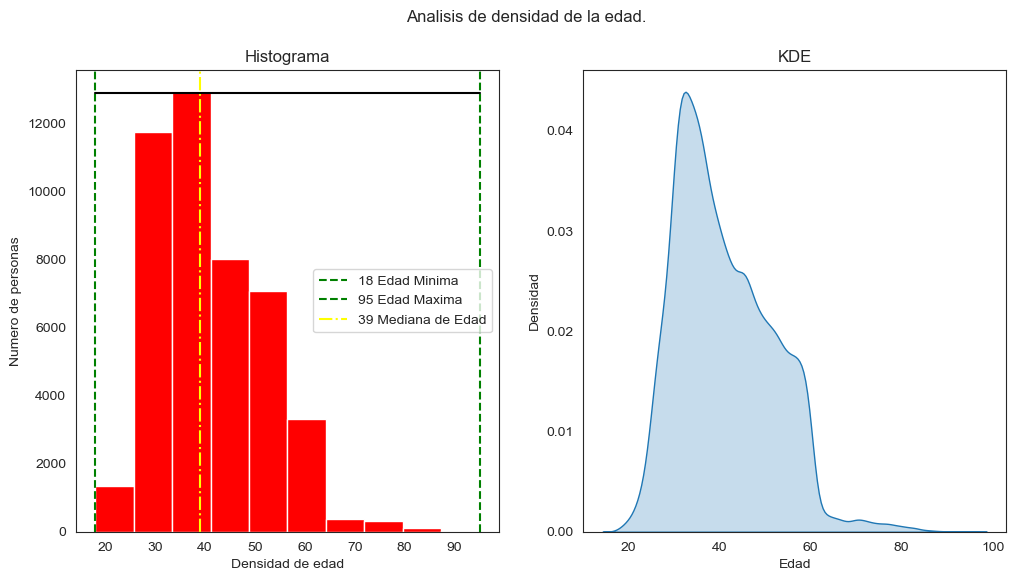

In [143]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].hist(x=df.age,color='r')
ax[0].set_xlabel('Densidad de edad')
ax[0].set_ylabel('Numero de personas')
ax[0].set_title('Histograma')
ax[0].axvline(x=18,ls='dashed',label='18 Edad Minima',color='green')
ax[0].axvline(x=95,ls='dashed',color='green',label='95 Edad Maxima')
ax[0].axvline(x=39,ls='dashdot',label='39 Mediana de Edad',color='yellow')
ax[0].axhline(y=12900,xmin=0.044,xmax=0.955,color='black')
ax[0].legend()

sns.kdeplot(fill=True,x=df.age,ax=ax[1])
ax[1].set_xlabel('Edad')
ax[1].set_ylabel('Densidad')
ax[1].set_title('KDE')

fig.suptitle('Analisis de densidad de la edad.')

In [100]:
medians = np.array([resample(df.age,n_samples=100).median() for x in range(1000)])
minimo,maximo,promedio,primer_quartile,segundo_quartile = int(medians.min()),int(medians.max()),int(medians.mean()),int(np.quantile(medians,0.25)),int(np.quantile(medians,0.75))
print(f'Valor minimo y valor maximo: {minimo} and {maximo}.\nPromedio: {promedio}.\nRango de confianza de 50 por ciento: {primer_quartile} al {segundo_quartile}.')

Valor minimo y valor maximo: 35 and 46.
Promedio: 39.
Rango de confianza de 50 por ciento: 38 al 40.


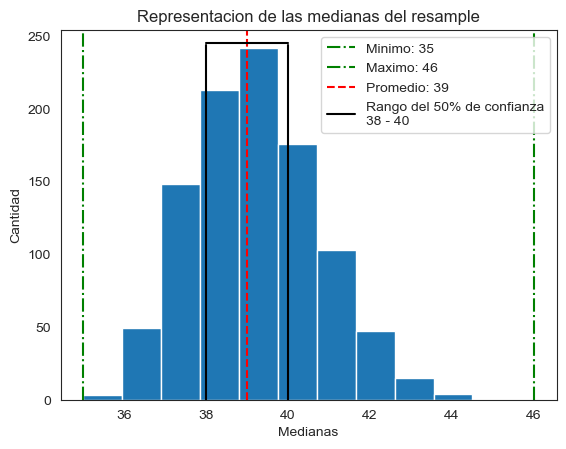

In [136]:
sns.set_style('white')
plt.hist(x=medianas)
plt.title('Representacion de las medianas del resample')
plt.xlabel('Medianas')
plt.ylabel('Cantidad')
plt.axvline(x=minimo,label='Minimo: 35',ls='dashdot',color='green')
plt.axvline(x=maximo,label='Maximo: 46',ls='dashdot',color='green')
plt.axvline(x=promedio,label='Promedio: 39',ls='dashed',color='red')
plt.axvline(x=primer_quartile,color='black',ymax=0.96)
plt.axvline(x=segundo_quartile,color='black',ymax=0.96)
plt.axhline(y=245,label='Rango del 50% de confianza\n38 - 40',color='black',xmin=0.293,xmax=0.458)

plt.legend()

((array([-4.16848918, -3.96166735, -3.84886815, ...,  3.84886815,
          3.96166735,  4.16848918]),
  array([18, 18, 18, ..., 94, 95, 95], dtype=int64)),
 (10.40835399459023, 40.93621021432836, 0.9801070738409398))

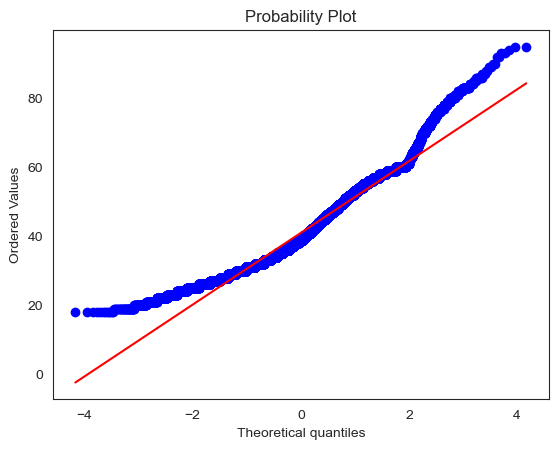

In [154]:
fig00,ax00 = plt.subplots()
probplot(df.age,plot=ax00)

Text(0, 0.5, 'Conteo')

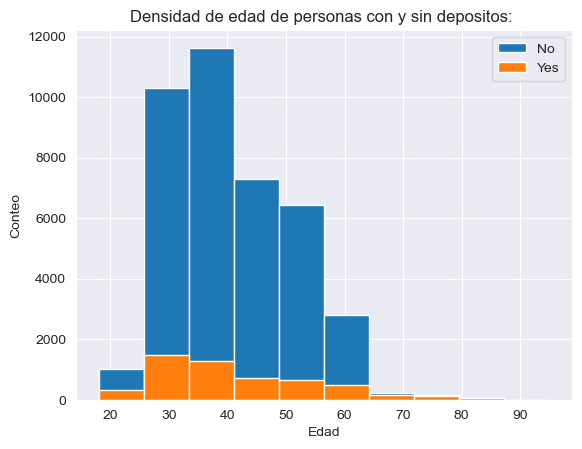

In [9]:
plt.hist(x=df.loc[df.bank_d=='no'].age,label='No')
plt.hist(x=df.loc[df.bank_d=='yes'].age,label='Yes')
plt.legend()
plt.title('Densidad de edad de personas con y sin depositos: ')
plt.xlabel('Edad')
plt.ylabel('Conteo')

In [6]:
labels= ['Kid','Young','Puro','Viejo']
bins = [0,20,40,60,float('inf')]
df['EdadClassification'] = pd.cut(df.age,bins=bins,labels=labels)

<Axes: title={'center': 'Marital Estatus segun etapa de edad'}, xlabel='Clasificacion de edad', ylabel='Numero de personas'>

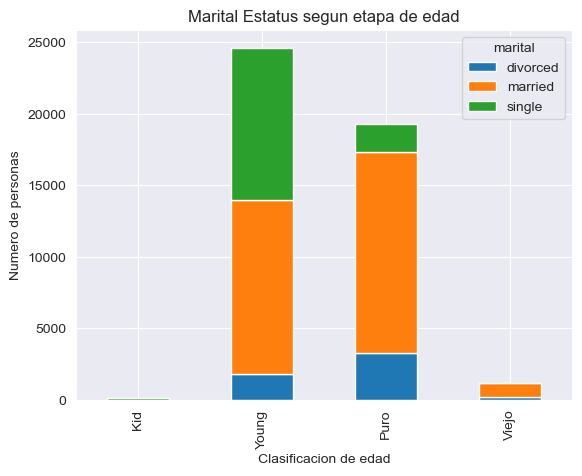

In [20]:
df.groupby('EdadClassification')['marital'].value_counts().unstack(fill_value=0).plot.bar(stacked=True,
                                                                                          ylabel='Numero de personas',
                                                                                         xlabel='Clasificacion de edad',
                                                                                         title='Marital Estatus segun etapa de edad')

In [10]:
print(f'Numero de trabajos distintos: {df.job.nunique()}')

Numero de trabajos distintos: 12


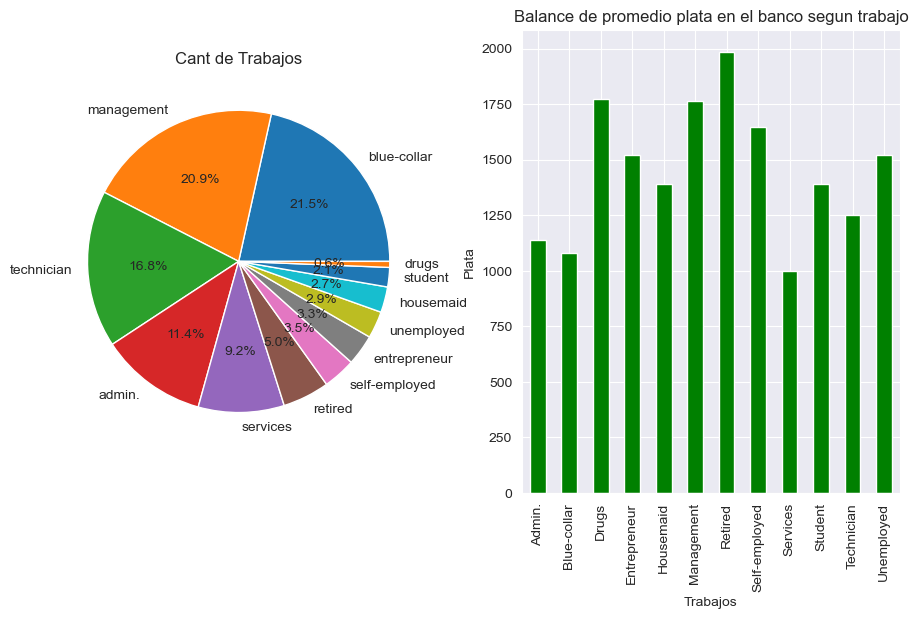

In [46]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
plt.tight_layout(pad=4)
df.job.value_counts().plot(kind='pie',ax=ax[0],
                          label='',
                          title='Cant de Trabajos',
                          autopct='%1.1f%%')
df.groupby('job')['balance'].mean().plot.bar(ax=ax[1],
                                            xlabel='Trabajos',
                                            ylabel='Plata',
                                            title='Balance de promedio plata en el banco segun trabajo',
                                           color='green')
ax[1].set_xticks(range(12),[x.capitalize() for x in sorted(df.job.unique())])

Text(0.5, 0.98, 'Relacion del trabajo con estado marital')

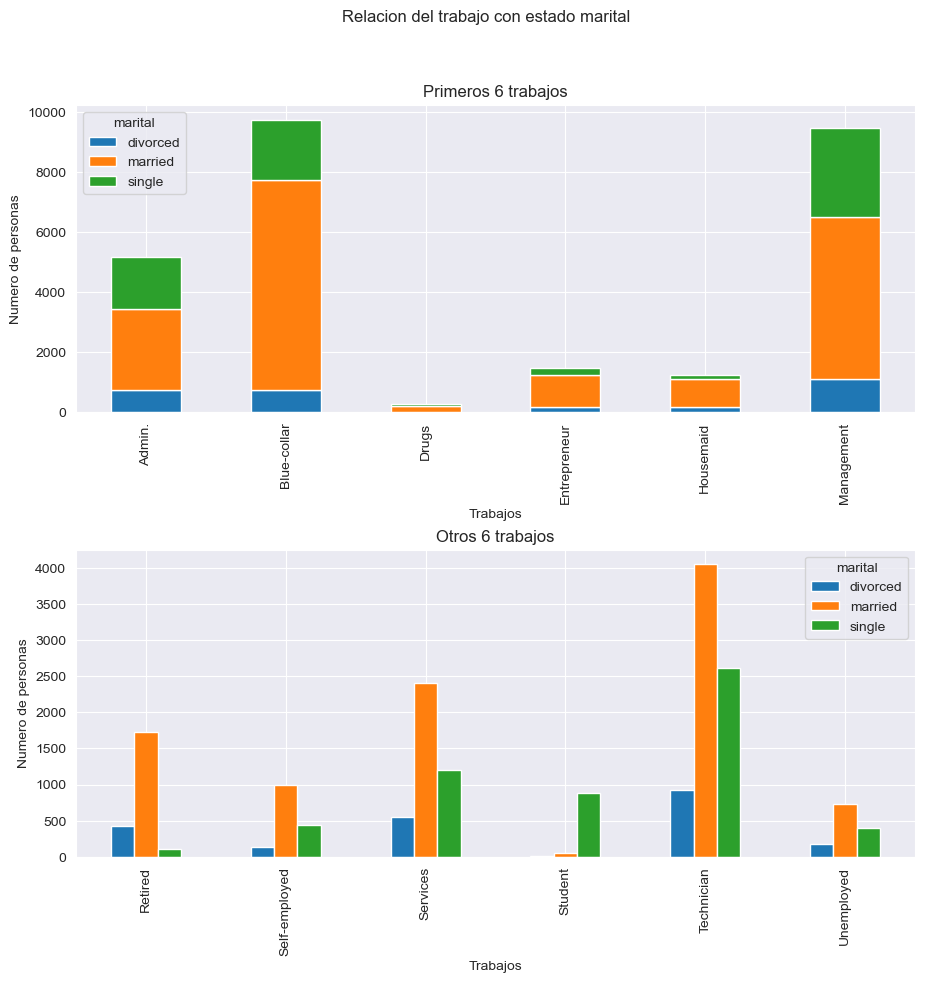

In [51]:
grupo1, grupo2 = sorted(df.job.unique())[0:6],sorted(df.job.unique())[6:]
fig0, ax0 = plt.subplots(2,1,figsize=(11,10))
plt.tight_layout(pad=8)
df.loc[df.job.isin(grupo1)].groupby('job')['marital'].value_counts().unstack(fill_value=0).plot.bar(ax=ax0[0],
                                                                                                    xlabel='Trabajos',
                                                                                                    ylabel='Numero de personas',
                                                                                                    title='Primeros 6 trabajos',
                                                                                                    stacked=True)
ax0[0].set_xticks(range(6),[x.capitalize() for x in grupo1])
df.loc[df.job.isin(grupo2)].groupby('job')['marital'].value_counts().unstack(fill_value=0).plot.bar(ax=ax0[1],
                                                                                                   xlabel='Trabajos',
                                                                                                   ylabel='Numero de personas',
                                                                                                   title='Otros 6 trabajos')
ax0[1].set_xticks(range(6),list(map(lambda x: x.capitalize(),grupo2)))

fig0.suptitle('Relacion del trabajo con estado marital')

([<matplotlib.axis.XTick at 0x214d2213510>,
 [Text(0, 0, 'Admin.'),
  Text(1, 0, 'Blue-collar'),
  Text(2, 0, 'Drugs'),
  Text(3, 0, 'Entrepreneur'),
  Text(4, 0, 'Housemaid'),
  Text(5, 0, 'Management'),
  Text(6, 0, 'Retired'),
  Text(7, 0, 'Self-employed'),
  Text(8, 0, 'Services'),
  Text(9, 0, 'Student'),
  Text(10, 0, 'Technician'),
  Text(11, 0, 'Unemployed')])

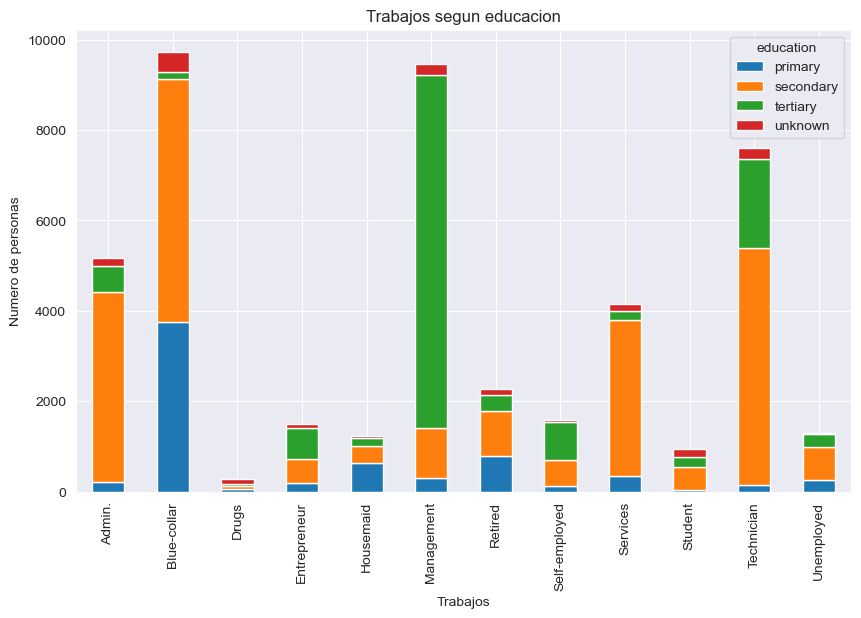

In [52]:
df.groupby('job')['education'].value_counts().unstack(fill_value=0).plot.bar(title='Trabajos segun educacion',
                                                                             xlabel='Trabajos',
                                                                            ylabel='Numero de personas',
                                                                            stacked=True,
                                                                            figsize=(10,6))
plt.xticks(range(12),[x.capitalize() for x in sorted(df.job.unique())])

In [34]:
print(f'Promedio y mediana de balance: {df.balance.mean()} and {df.balance.median()}\nDesviacion Estandar y Varianza: {df.balance.std()} and {df.balance.var()}')

Promedio y mediana de balance: 1362.2720576850766 and 448.0
Desviacion Estandar y Varianza: 3044.7658291686002 and 9270598.954472754


<Axes: title={'center': 'Mediana de balance segun educacion'}, xlabel='Educacion'>

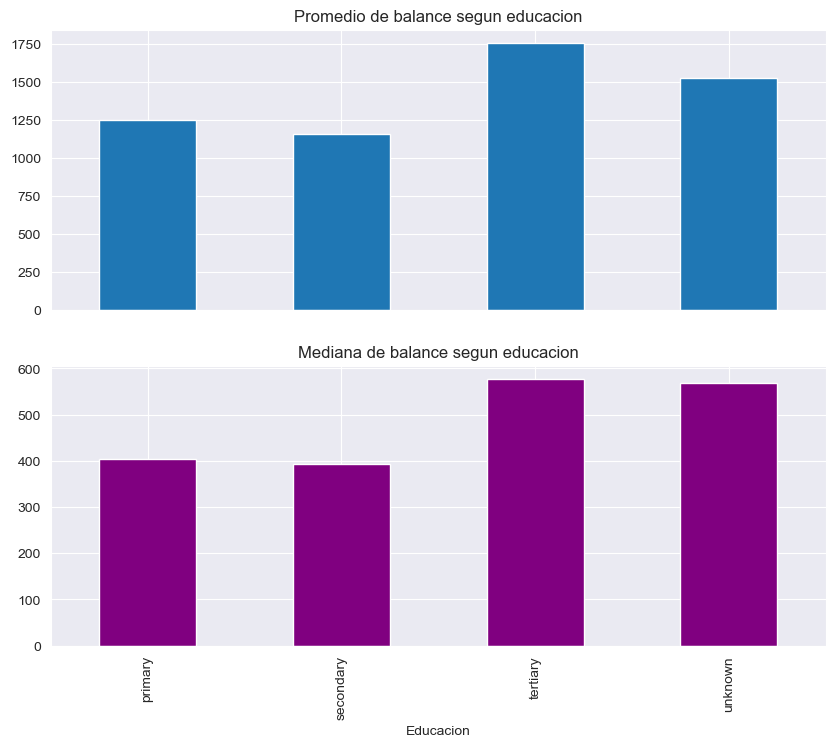

In [128]:
sns.set_style('darkgrid')
fig1, ax1 = plt.subplots(2,1,figsize=(10,8),sharex=True)
df.groupby('education')['balance'].mean().plot.bar(ax=ax1[0],title='Promedio de balance segun educacion')
df.groupby('education')['balance'].median().plot.bar(ax=ax1[1],title='Mediana de balance segun educacion',color='purple',xlabel='Educacion')

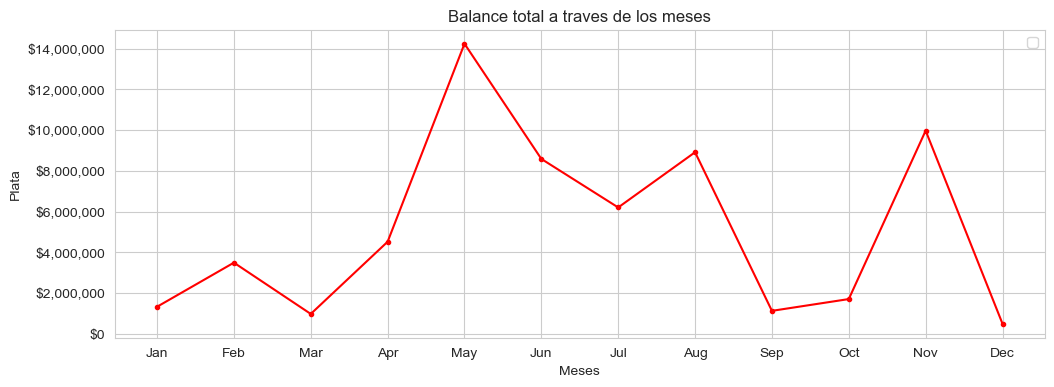

In [10]:
sns.set_style('whitegrid')
lineplot= df.groupby('month')['balance'].sum().reset_index(name='Plata')
lineplot.month = pd.to_datetime(lineplot.month,format='%m').dt.strftime('%b')
lineplot.set_index('month',inplace=True)
lineplot.plot(color='red',
            xlabel='Meses',
            ylabel='Plata',
            marker='.',
             figsize=(12,4),
             title='Balance total a traves de los meses')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.xticks(np.arange(0,12),lineplot.index.tolist())
plt.legend('')

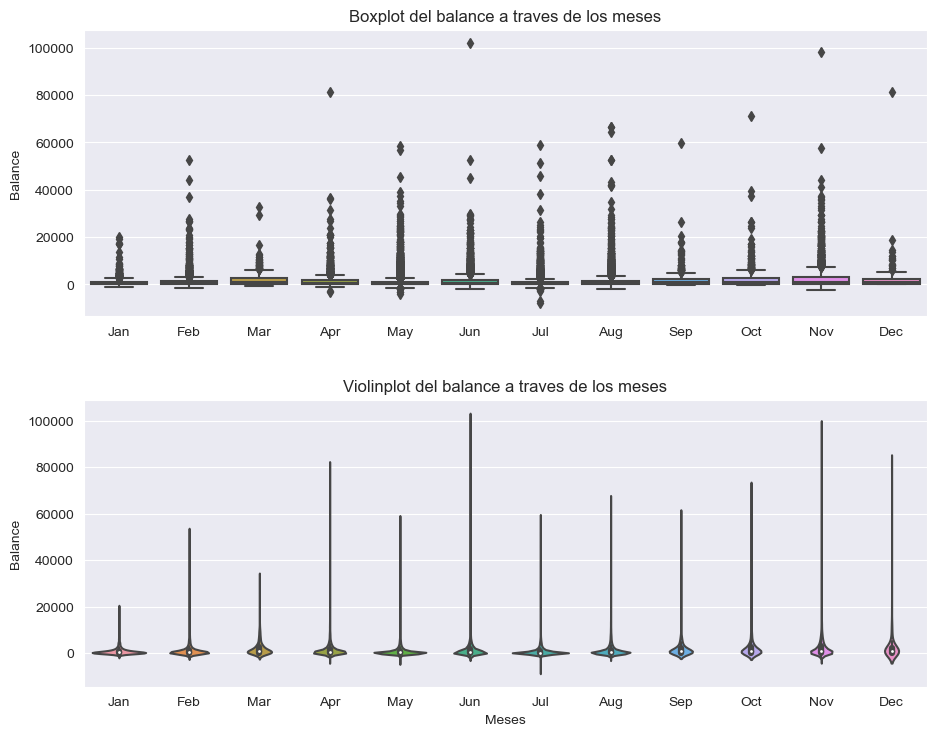

In [32]:
sns.set_style('darkgrid')
fig3, ax3 = plt.subplots(2,1,figsize=(10,8))

sns.boxplot(x=df.month,y=df.balance,ax=ax3[0])
ax3[0].set_title('Boxplot del balance a traves de los meses')
ax3[0].set_xlabel('')
ax3[0].set_ylabel('Balance')
ax3[0].set_xticks(range(12),lineplot.index.tolist())

sns.violinplot(x=df.month,y=df.balance,ax=ax3[1])
ax3[1].set_title('Violinplot del balance a traves de los meses')
ax3[1].set_xlabel('Meses')
ax3[1].set_ylabel('Balance')
ax3[1].set_xticks(range(12),lineplot.index.tolist())

plt.tight_layout(pad=3)

([<matplotlib.axis.XTick at 0x25c55755f90>,
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Apr'),
  Text(4, 0, 'May'),
  Text(5, 0, 'Jun'),
  Text(6, 0, 'Jul'),
  Text(7, 0, 'Aug'),
  Text(8, 0, 'Sep'),
  Text(9, 0, 'Oct'),
  Text(10, 0, 'Nov'),
  Text(11, 0, 'Dec')])

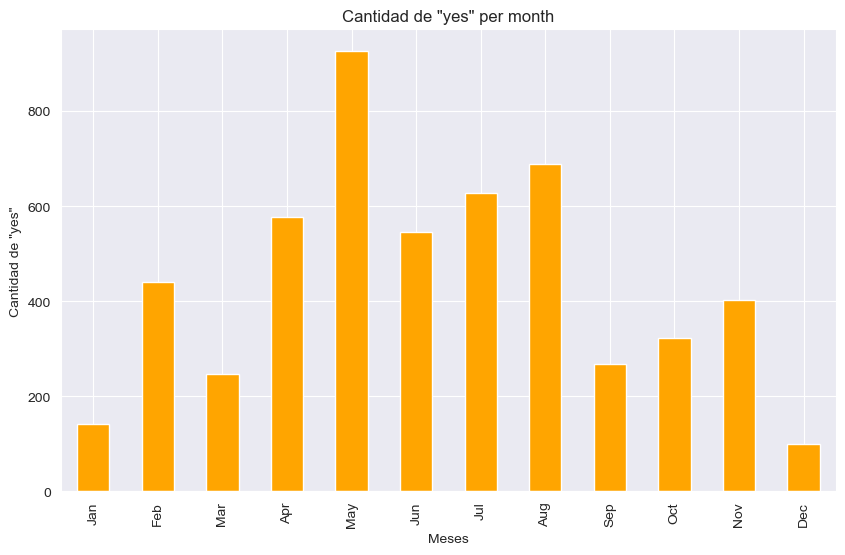

In [42]:
df.loc[df.bank_d=='yes'].groupby('month')['bank_d'].count().plot.bar(xlabel='Meses',
                                                                    ylabel='Cantidad de "yes"',
                                                                    title='Cantidad de "yes" per month',
                                                                    figsize=(10,6),
                                                                    color='orange')
plt.xticks(range(12),lineplot.index.tolist())

Text(0.5, 0.98, 'Countplots')

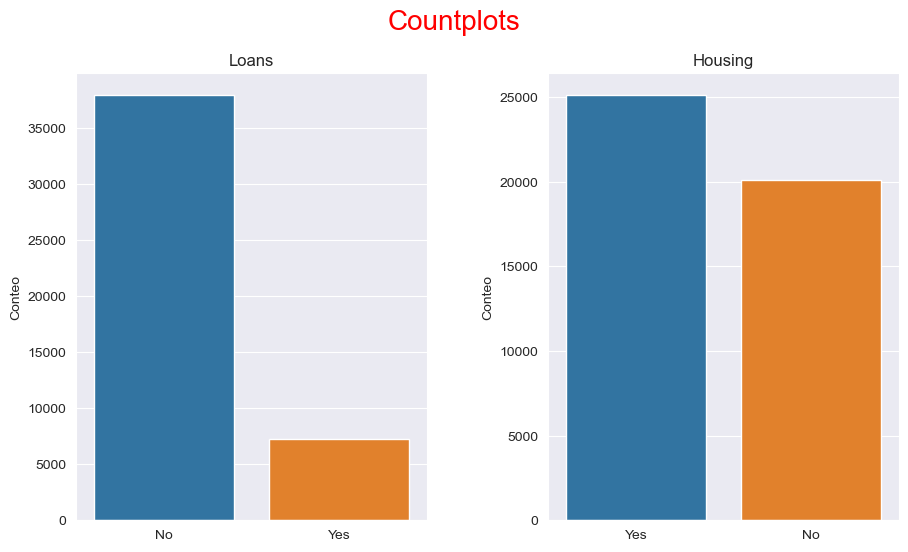

In [19]:
fig4, ax4 = plt.subplots(1,2,figsize=(10,6))
sns.countplot(x=df.loan,ax=ax4[0])
ax4[0].set_xlabel('')
ax4[0].set_ylabel('Conteo')
ax4[0].set_title('Loans')
ax4[0].set_xticks([0,1],['No','Yes'])

sns.countplot(x=df.housing,ax=ax4[1])
ax4[1].set_xlabel('')
ax4[1].set_ylabel('Conteo')
ax4[1].set_title('Housing')
ax4[1].set_xticks([0,1],['Yes','No'])

plt.tight_layout(pad=4)
fig4.suptitle('Countplots',color='r',size=20)

([<matplotlib.axis.XTick at 0x25c5e595d90>,
 [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

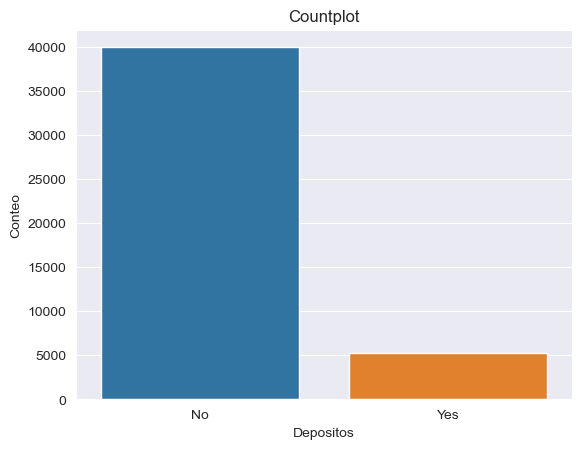

In [151]:
sns.countplot(x=df.bank_d)
plt.ylabel('Conteo')
plt.xlabel('Depositos')
plt.title('Countplot')
plt.xticks([0,1],['No','Yes'])

Text(0.5, 0.98, 'Relacion Campañas - Depositos Bancarios')

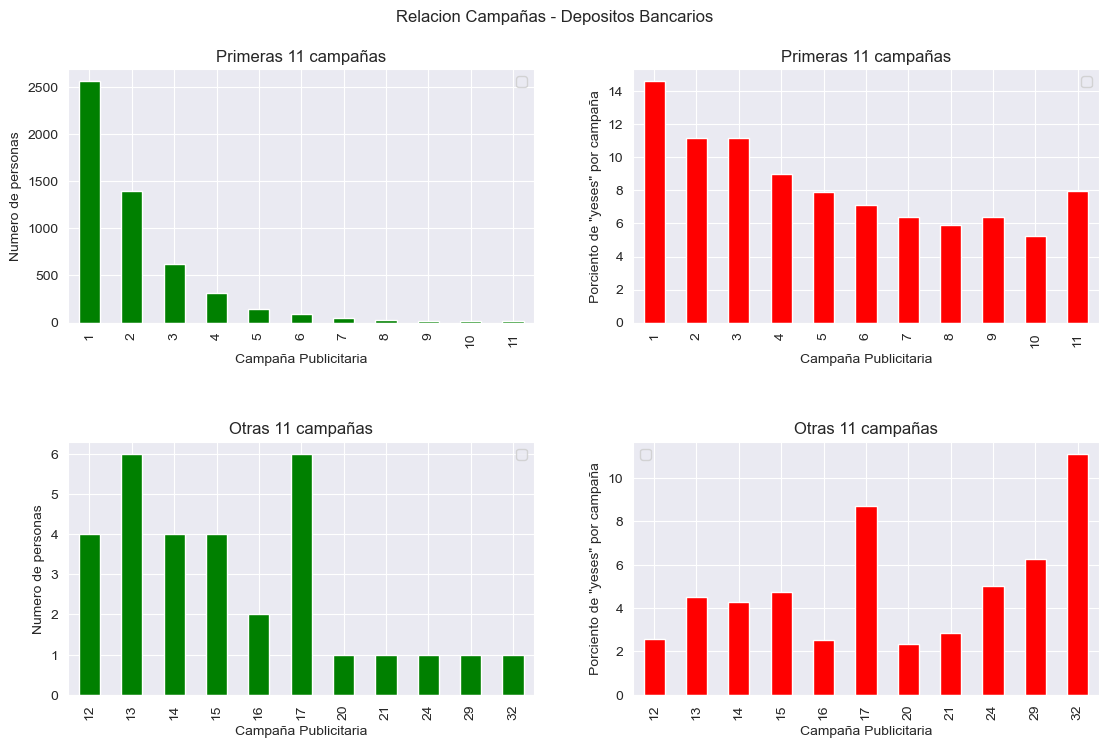

In [150]:
cam = df.groupby('campaign')['bank_d'].value_counts().reset_index(name='conteo')
cantidad = df.groupby('campaign')['bank_d'].count().loc[yeses.index]
yeses = cam.loc[cam.bank_d=='yes',['campaign','conteo']].set_index('campaign').squeeze()
no_yeses = pd.Series(index=yeses.index,data=round((yeses/cantidad)*100,2))

fig5, ax5 = plt.subplots(2,2,figsize=(12,8))

#solo yeses
yeses.iloc[:11].plot.bar(ax=ax5[0,0],color='green')
ax5[0,0].legend('')
ax5[0,0].set_xlabel('Campaña Publicitaria')
ax5[0,0].set_ylabel('Numero de personas')
ax5[0,0].set_title('Primeras 11 campañas')

yeses.iloc[11:].plot.bar(ax=ax5[1,0],color='green')
ax5[1,0].legend('')
ax5[1,0].set_xlabel('Campaña Publicitaria')
ax5[1,0].set_ylabel('Numero de personas')
ax5[1,0].set_title('Otras 11 campañas')

#porcentajes
no_yeses.iloc[:11].plot.bar(ax=ax5[0,1],color='red')
ax5[0,1].legend('')
ax5[0,1].set_xlabel('Campaña Publicitaria')
ax5[0,1].set_ylabel('Porciento de "yeses" por campaña')
ax5[0,1].set_title('Primeras 11 campañas')

no_yeses.iloc[11:].plot.bar(ax=ax5[1,1],color='red')
ax5[1,1].legend('')
ax5[1,1].set_xlabel('Campaña Publicitaria')
ax5[1,1].set_ylabel('Porciento de "yeses" por campaña')
ax5[1,1].set_title('Otras 11 campañas')


plt.tight_layout(pad=4)
fig5.suptitle('Relacion Campañas - Depositos Bancarios')

# Segundo intento: 

In [13]:
df = pd.read_csv(r'D:\Programacion\Datasets\bank_deposits\train.csv')

In [25]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,bank_d,EdadClassification
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,5,261,1,-1,0,unknown,no,Puro
1,44,technician,single,secondary,no,29,yes,no,unknown,5,5,151,1,-1,0,unknown,no,Puro
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,5,76,1,-1,0,unknown,no,Young
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,5,92,1,-1,0,unknown,no,Puro
4,33,drugs,single,unknown,no,1,no,no,unknown,5,5,198,1,-1,0,unknown,no,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,11,977,3,-1,0,unknown,yes,Puro
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,11,456,2,-1,0,unknown,yes,Viejo
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,11,1127,5,184,3,success,yes,Viejo
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,11,508,4,-1,0,unknown,no,Puro


In [14]:
df.rename(columns={'y':'bank_d'},inplace=True)
df.month = pd.to_datetime(df.month,format='%b').dt.month
df.job.replace({'unknown':'drugs'},inplace=True)
labels= ['Kid','Young','Puro','Viejo']
bins = [0,20,40,60,float('inf')]
df['EdadClassification'] = pd.cut(df.age,bins=bins,labels=labels)

C:\Users\Mina\AppData\Local\Temp\ipykernel_8900\2311808093.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.job.replace({'unknown':'drugs'},inplace=True)


# Feature Engineering

<Axes: >

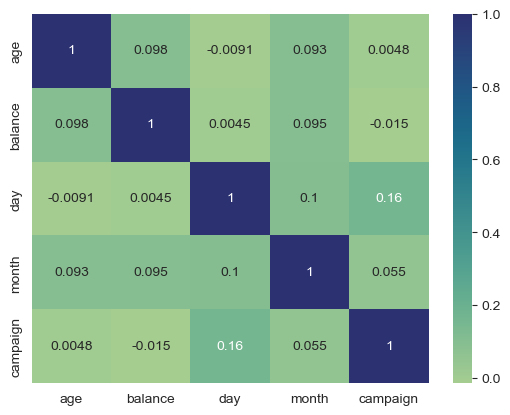

In [179]:
sns.heatmap(df.select_dtypes('number').corr(),annot=True,cmap='crest')

In [11]:
df.month = pd.to_datetime(df.month,format='%m').dt.strftime('%b')
df.campaign = df.campaign.astype('object')

In [12]:
dfc = df.copy()
dfc.bank_d.replace({'no':0,'yes':1},inplace=True)
dfc = pd.concat([dfc.select_dtypes('number'),pd.get_dummies(dfc[dfc.select_dtypes(exclude='number').drop('EdadClassification',axis=1).columns])],axis=1)

C:\Users\Mina\AppData\Local\Temp\ipykernel_8900\1714959023.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfc.bank_d.replace({'no':0,'yes':1},inplace=True)
C:\Users\Mina\AppData\Local\Temp\ipykernel_8900\1714959023.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfc.bank_d.replace({'no':0,'

In [9]:
dfc

,age,balance,bank_d,job_admin.,job_blue-collar,job_drugs,job_entrepreneur,job_housemaid,job_management,job_retired,...,campaign_39,campaign_41,campaign_43,campaign_44,campaign_46,campaign_50,campaign_51,campaign_55,campaign_58,campaign_63
0,58,2143,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,44,29,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,47,1506,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45207,71,1729,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
45208,72,5715,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
45209,57,668,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Second Feature Engineering 

<Axes: >

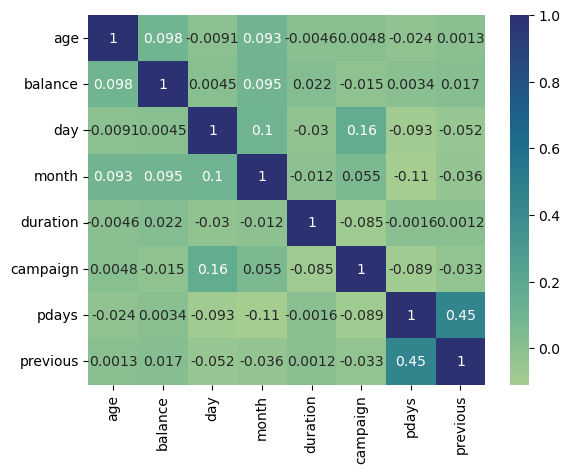

In [26]:
sns.heatmap(df.select_dtypes('number').corr(),annot=True,cmap='crest')

In [15]:
df.month = pd.to_datetime(df.month,format='%m').dt.strftime('%b')
df.campaign = df.campaign.astype('object')

In [16]:
dfc = df.copy()
dfc.bank_d.replace({'no':0,'yes':1},inplace=True)
dfc = pd.concat([dfc.select_dtypes('number'),pd.get_dummies(dfc[dfc.select_dtypes(exclude='number').drop('EdadClassification',axis=1).columns])],axis=1)

C:\Users\Mina\AppData\Local\Temp\ipykernel_8900\1714959023.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfc.bank_d.replace({'no':0,'yes':1},inplace=True)
C:\Users\Mina\AppData\Local\Temp\ipykernel_8900\1714959023.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfc.bank_d.replace({'no':0,'

In [17]:
dfc

,age,balance,day,duration,pdays,previous,bank_d,job_admin.,job_blue-collar,job_drugs,...,campaign_46,campaign_50,campaign_51,campaign_55,campaign_58,campaign_63,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,-1,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,44,29,5,151,-1,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,33,2,5,76,-1,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,47,1506,5,92,-1,0,0,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,33,1,5,198,-1,0,0,False,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,17,977,-1,0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,True
45207,71,1729,17,456,-1,0,1,False,False,False,...,False,False,False,False,False,False,False,False,False,True
45208,72,5715,17,1127,184,3,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False
45209,57,668,17,508,-1,0,0,False,True,False,...,False,False,False,False,False,False,False,False,False,True


# ML

In [18]:
X = dfc.drop('bank_d',axis=1)
y = dfc.bank_d
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## XGBClassifier

In [20]:
space = {'n_estimators': hp.quniform('n_estimators',50,150,1),'max_depth':hp.quniform('max_depth',10,30,1),'learning_rate': hp.uniform('learning_rate',0.001,1),'subsample': hp.uniform('subsample',0,1)}
def objective(space):
    model = XGBClassifier(n_estimators=int(space['n_estimators']),max_depth=int(space['max_depth']),learning_rate=space['learning_rate'],subsample=space['subsample'])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred)
    return {'loss': -f1, 'status': STATUS_OK }
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)


100%|██████████| 100/100 [03:39<00:00,  2.19s/trial, best loss: -0.5701030927835051]


In [21]:
best_hyperparams

{'learning_rate': 0.38689965737718535,
 'max_depth': 21.0,
 'n_estimators': 70.0,
 'subsample': 0.7750043091187842}

In [22]:
xgb = XGBClassifier(n_estimators=int(best_hyperparams['n_estimators']),max_depth=int(best_hyperparams['max_depth']),learning_rate=best_hyperparams['learning_rate'],subsample=best_hyperparams['subsample'])
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

In [23]:
print(f'Accuracy: {accuracy_score(y_test,y_pred)}\nPrecision: {precision_score(y_test,y_pred)}\nRecall:{recall_score(y_test,y_pred)}\nF1: {f1_score(y_test,y_pred)}')

Accuracy: 0.9077739688156585
Precision: 0.6483001172332943
Recall:0.5087396504139834
F1: 0.5701030927835051


## BaggingKNN(Mierda)

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [26]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [83]:
params= {'n_neighbors':range(1,16),'leaf_size':range(1,20),'p':[1,2]}
grid = GridSearchCV(KNeighborsClassifier(),param_grid=params)
grid.fit(X_train_std,y_train)

KeyboardInterrupt: 

In [ ]:
grid.best_params_

In [70]:
knn = KNeighborsClassifier(n_neighbors=,leaf_size=,p=)
knn.fit(X_train_std,y_train)
y_pred = knn.predict(X_test_std)

In [71]:
print(f'Accuracy: {accuracy_score(y_test,y_pred)}\nPrecision: {precision_score(y_test,y_pred)}\nRecall:{recall_score(y_test,y_pred)}\nF1: {f1_score(y_test,y_pred)}')

Accuracy: 0.8870949906004645
Precision: 0.5408921933085502
Recall:0.27323943661971833
F1: 0.363069245165315


## Bagging LinearSVC

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [96]:
model = BaggingClassifier(LinearSVC(C=10,dual=False),n_estimators=10)
model.fit(X_train_std, y_train)
pred = model.predict(X_test_std)

In [27]:
space = {'n_estimators': hp.quniform('n_estimators',50,150,1),'C':hp.quniform('C',1,30,1)}
def objective(space):
    model = BaggingClassifier(LinearSVC(C=int(space['C']),dual=False),n_estimators=int(space['n_estimators']))
    model.fit(X_train_std, y_train)
    pred = model.predict(X_test_std)
    f1 = f1_score(y_test, pred)
    return {'loss': -f1, 'status': STATUS_OK }
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 15,
                        trials = trials)

100%|██████████| 15/15 [13:30<00:00, 54.07s/trial, best loss: -0.43174603174603177]


In [28]:
best_hyperparams

{'C': 27.0, 'n_estimators': 73.0}

In [29]:
svc = BaggingClassifier(LinearSVC(C=int(best_hyperparams['C']),dual=False),n_estimators=int(best_hyperparams['n_estimators']))
svc.fit(X_train_std,y_train)
y_pred = svc.predict(X_test_std)

In [30]:
print(f'Accuracy: {accuracy_score(y_test,y_pred)}\nPrecision: {precision_score(y_test,y_pred)}\nRecall: {recall_score(y_test,y_pred)}\nF1: {f1_score(y_test,y_pred)}')

Accuracy: 0.900364923144974
Precision: 0.6905737704918032
Recall: 0.31002759889604414
F1: 0.42793650793650784
